<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телескоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [4]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("/content/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [5]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [6]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [7]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [8]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [9]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

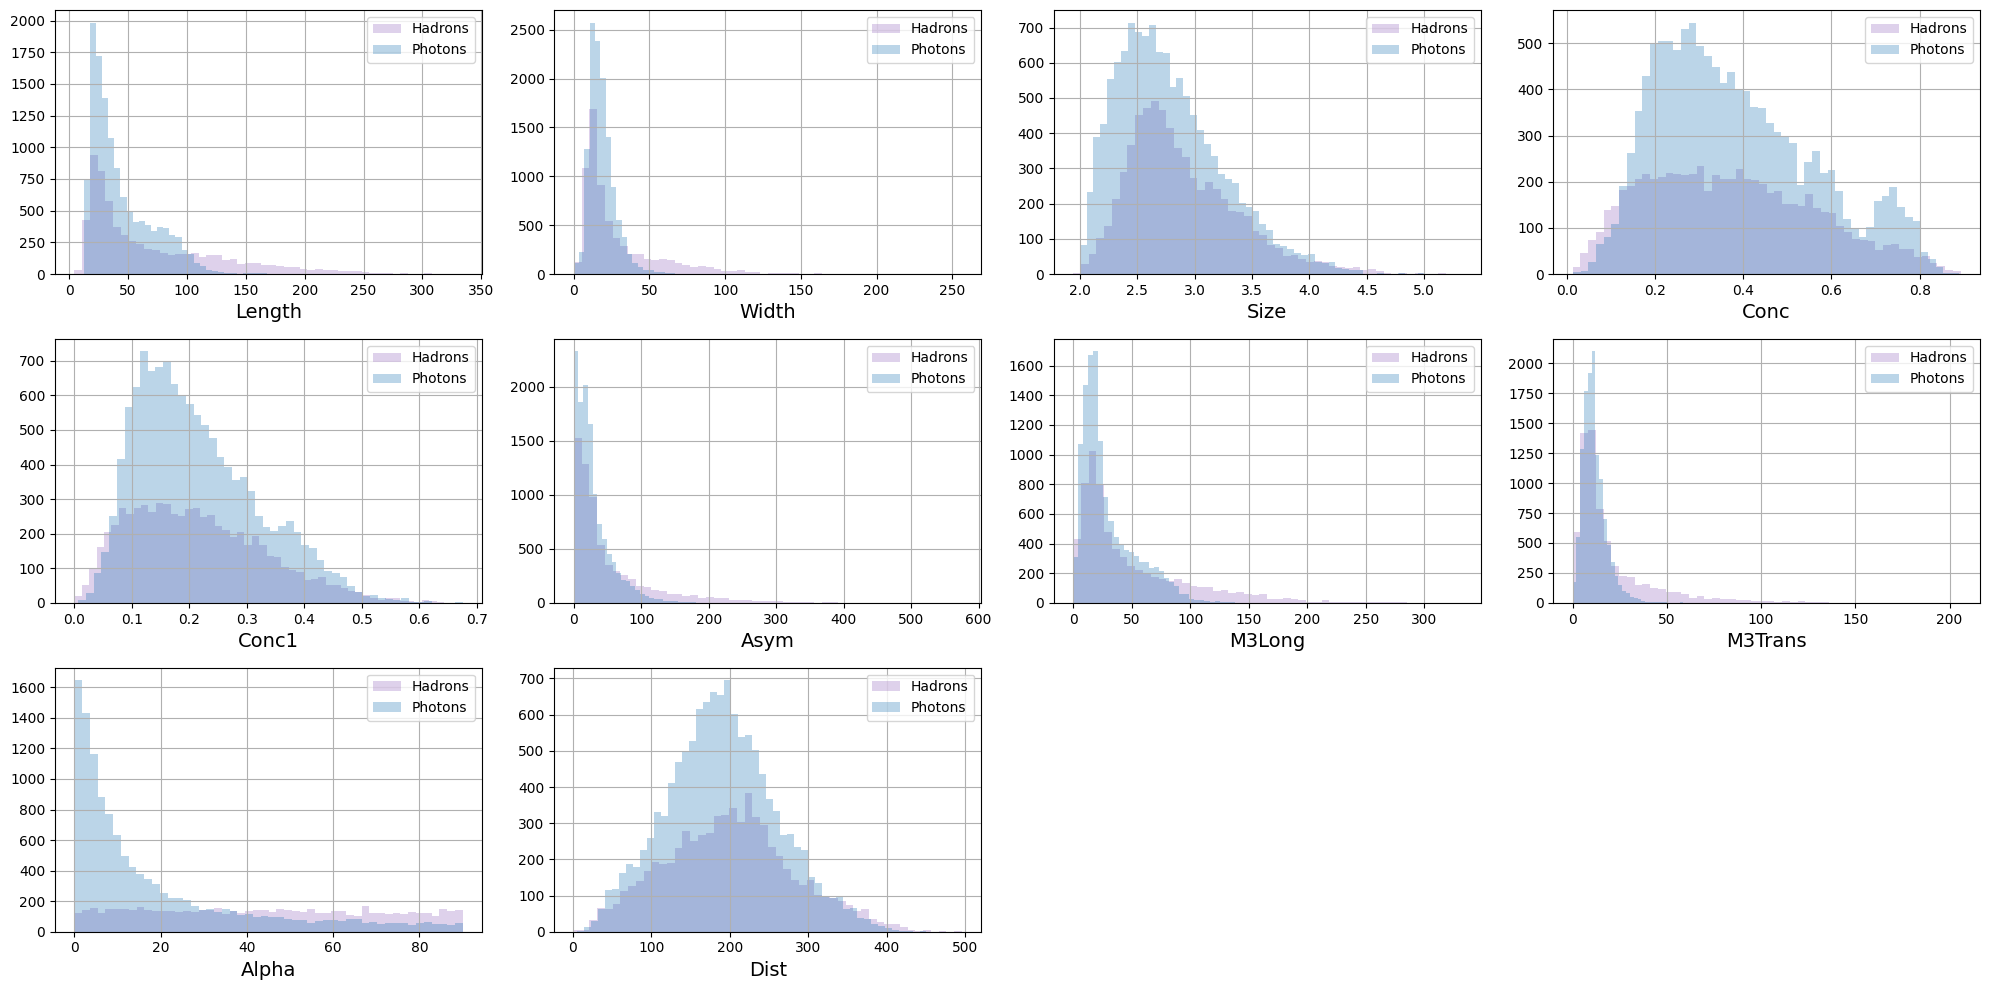

In [9]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [12]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение целевой переменной внутри train и test выборки. Совпадает ли оно? Есть ли идеи почему так?

__Подсказка__: посмотрите на клеточку с разделением данных

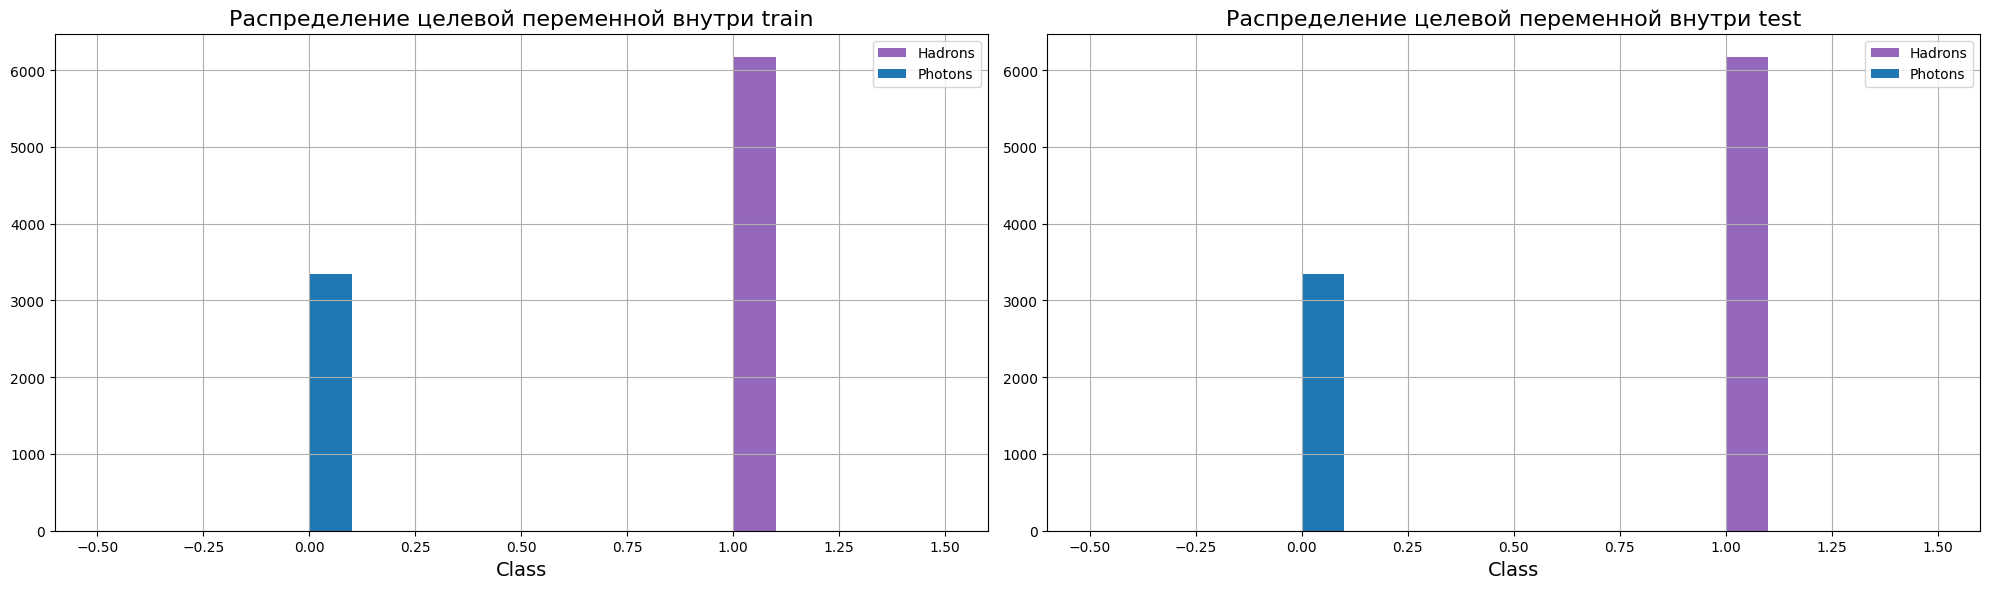

In [11]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.grid()
plt.hist(y_train[y_train==1], label="Hadrons", color="C4")
plt.hist(y_train[y_train==0], label="Photons", color="C0")
plt.title('Распределение целевой переменной внутри train', size=16)
plt.legend(loc="best")
plt.xlabel('Class', size=14)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.grid()
plt.hist(y_test[y_test==1], label="Hadrons", color="C4")
plt.hist(y_test[y_test==0], label="Photons", color="C0")
plt.title('Распределение целевой переменной внутри test', size=16)
plt.legend(loc="best")
plt.xlabel('Class', size=14)
plt.tight_layout()

In [12]:
print(len(y_train[y_train==0]) == len(y_test[y_test==0]))
print(len(y_train[y_train==1]) == len(y_test[y_test==1]))

True
True


**Вывод:** Распределения целевой переменной внутри train и test совпадают, так как при разделении использовался параметр stratify=y, который сохраняет соотношение классов, а также test_size=0.5, поэтому количественные значения также равны.

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [13]:
from sklearn.preprocessing import QuantileTransformer
QT = QuantileTransformer(output_distribution='normal')
X_train = QT.fit_transform(X_train)
X_test = QT.transform(X_test)

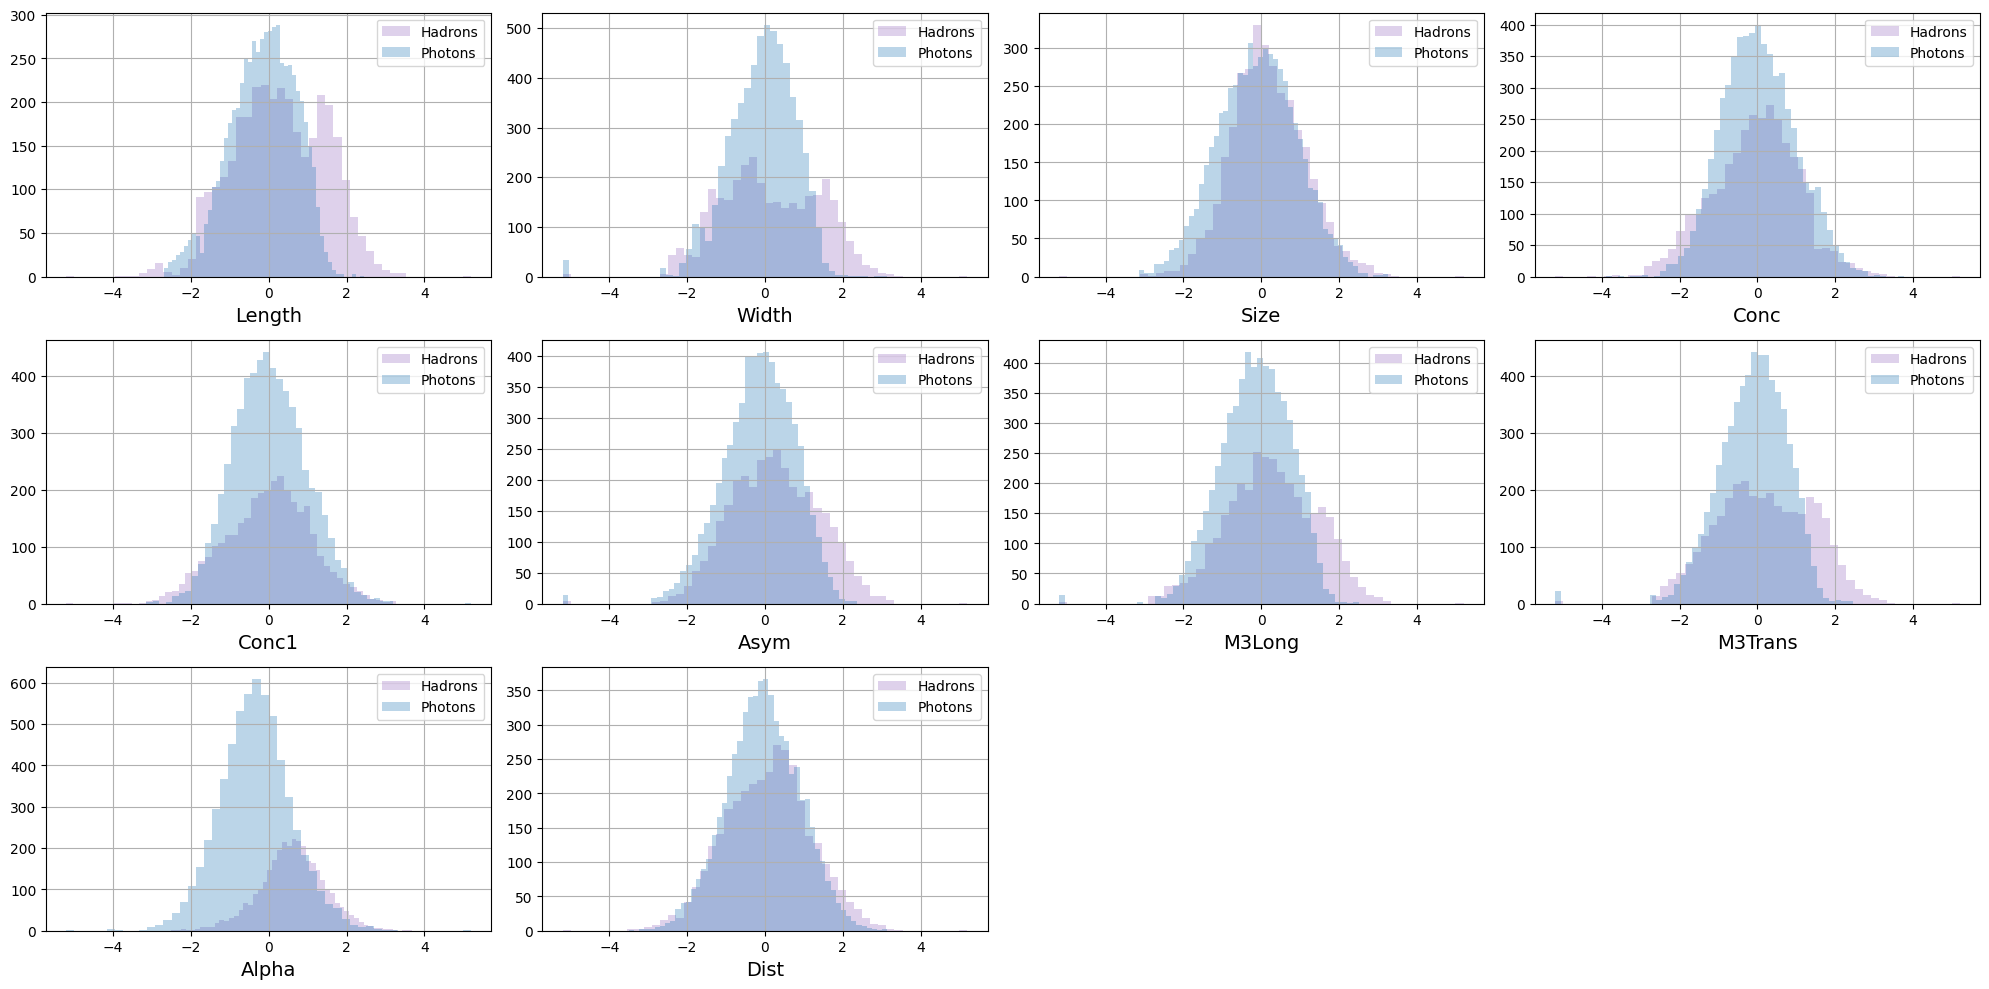

In [14]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

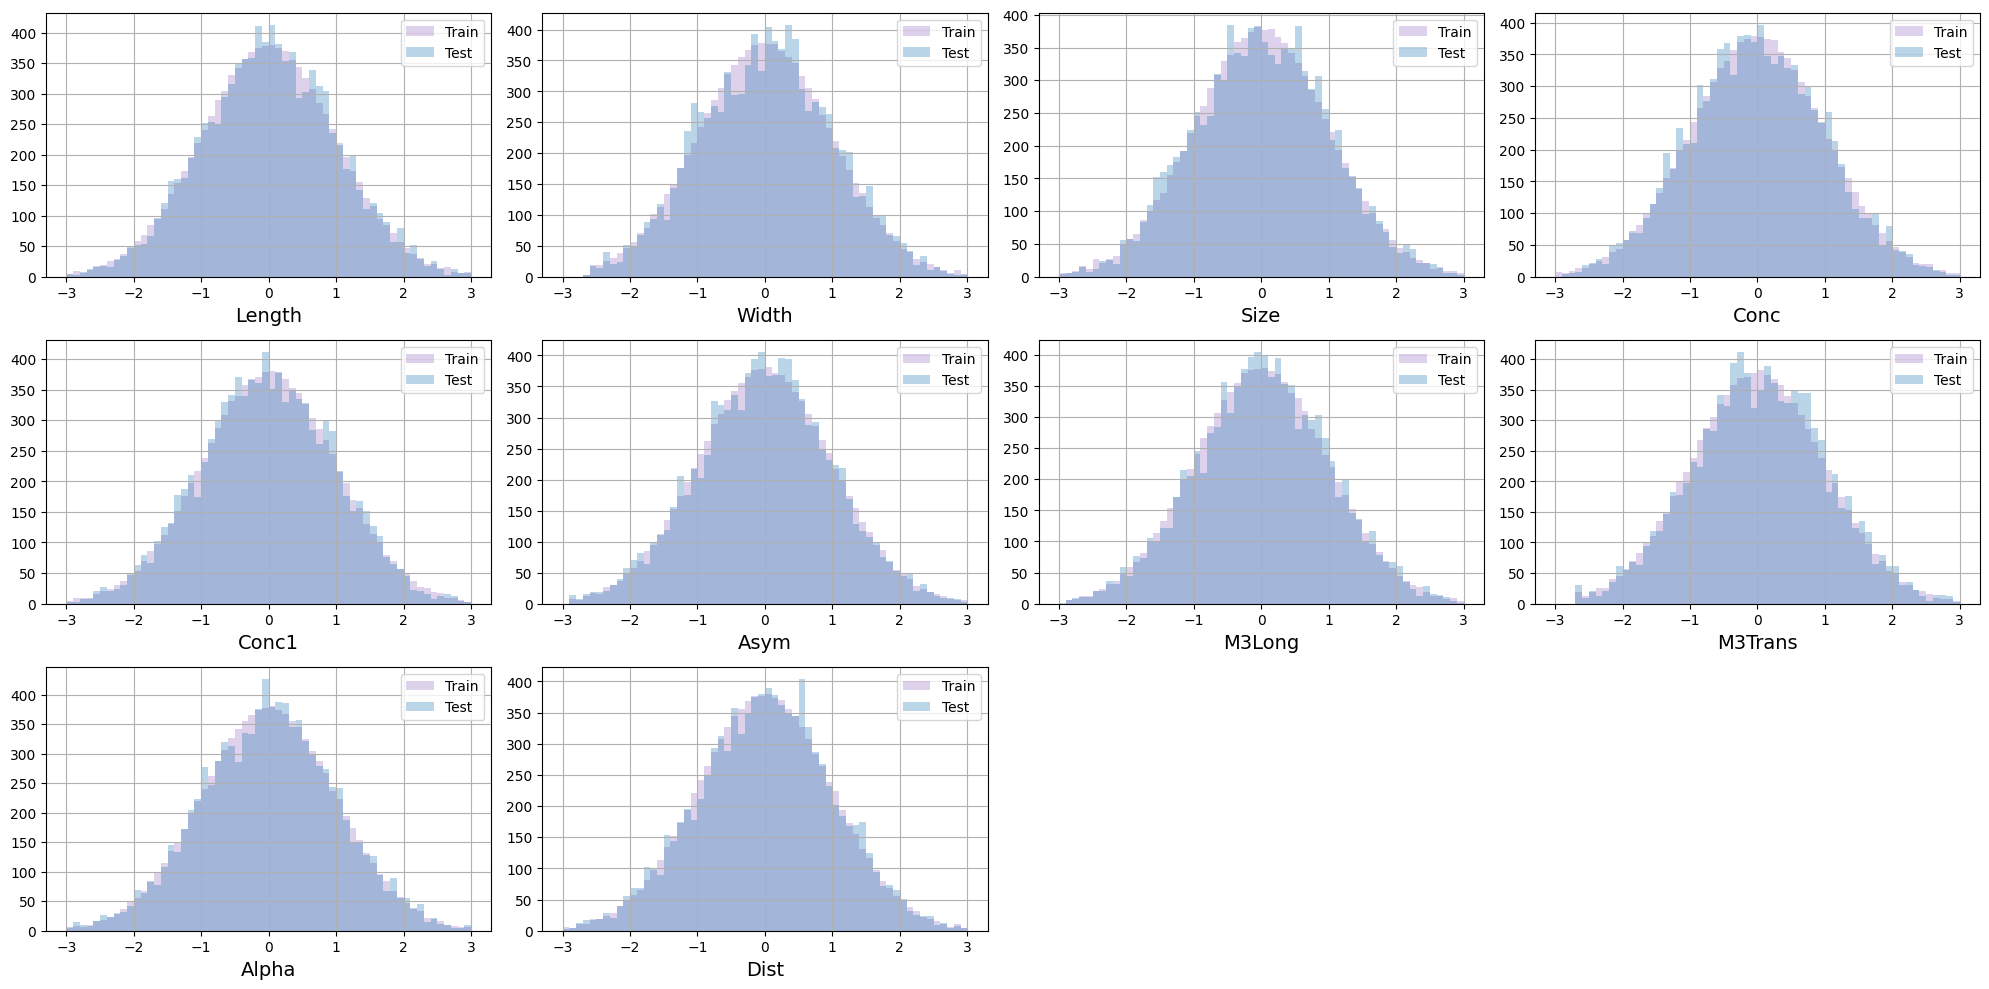

In [15]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + \frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
DEVICE

device(type='cpu')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [18]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, y):
        zy = torch.cat((z.to(DEVICE), y.to(DEVICE)), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [19]:
def generate(generator, y, latent_dim):
    X_fake = generator(torch.normal(0, 1, size=(len(y), latent_dim)), torch.tensor(y).float())
    return X_fake

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [20]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

**Вывод:** Оригинальный GAN использует бинарную кросс-энтропию в качестве функции потерь и для этого требуется вероятности (фейковые данные или нет). Отрицательные значения даже нельзя поставить в логарифм. Поэтому выход дискриминатора должен находился в диапазоне [0,1], и для этого используется сигмоида на последнем слое.

В нашем случае мы используем модель WGAN, у которой отличается функция потерь (не бинарная кросс-энтропии), и она вычисляет расстояние. Использование функции активации в конце будет искажать эту метрику, поэтому сигмоиду не используем.

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

def other_agent_score(X_real, y_real, X_fake, y_fake):


    X = np.concatenate((X_real, X_fake))
    y = np.concatenate((y_real, y_fake))

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

    lin_reg = LogisticRegression()
    boosting = GradientBoostingClassifier()

    lin_reg.fit(X_train, y_train)
    lin_reg_pred = lin_reg.predict(X_test)

    boosting.fit(X_train, y_train)
    boosting_pred = boosting.predict(X_test)

    lin_reg_score = accuracy_score(lin_reg_pred, y_test)
    boosting_score = accuracy_score(boosting_pred, y_test)

    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

**Вывод:** Нас бы удовлетворило больше все значение accuracy score равное 0.5, так как в этом случае модель не может различить наши сгенерированные данные от реальных, что говорит об успешной генерации.

Если бы accuracy score был значительно ниже 0.5, то наш дискриминатор слабый и не может отличить даже явно сгенерированные данные от реальных, что может свидетельствовать о проблемах в обучении дискриминатора. Если бы accuracy score был значительно выше 0.5, то наш дискриминатор уверенно отличает реальные данные от сгенерированных, следовательно, сгенерированные данные не очень похожи на реальные, наша задача не выполнена.

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [22]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []
        self.prior = torch.distributions.Normal(torch.zeros(10).to(DEVICE), torch.ones(10).to(DEVICE))

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                real_objects = real_batch.to(DEVICE)

                # генерируем новые объекты
                num_objects = real_objects.shape[0]
                z = self.prior.sample((num_objects,))
                gen_objects = self.generator(z, cond_batch)

                # считаем скоры
                real_objects_scores, gen_objects_scores = torch.split(
                    self.discriminator(torch.cat([real_objects, gen_objects], dim=0), torch.cat([cond_batch, cond_batch], dim=0)),
                    num_objects
                )

                if i % self.n_critic == 0:
                    # делаем шаг обучения генератора
                    self.opt_gen.zero_grad()
                    gen_loss = -gen_objects_scores.mean()
                    gen_loss.backward()
                    self.opt_gen.step()

                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)
                else:
                    # делаем шаг обучения дискриминатора
                    self.opt_disc.zero_grad()
                    discr_loss = -real_objects_scores.mean() + gen_objects_scores.mean()
                    discr_loss.backward()
                    self.opt_disc.step()

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            indexes = torch.randint(0, len(X_real), (1000,))

            X_real_sample = torch.tensor(X_real[indexes], dtype=torch.float, device=DEVICE)
            y_real_sample = torch.ones((1000, ))

            Z_noise = torch.normal(0, 1, (1000, self.latent_dim))
            y_fake = torch.randint(0, 2, (1000, 1), device=DEVICE)
            X_fake_sample = self.generator(Z_noise, y_fake).clone().detach().to(dtype=torch.float, device=DEVICE)
            y_fake_sample = torch.zeros((1000, ))

            other_agent_score(X_real_sample.cpu().detach().numpy(), y_real_sample.cpu().detach().numpy(),
                              X_fake_sample.cpu().detach().numpy(), y_fake_sample.cpu().detach().numpy())

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [23]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Linear regression score: 0.608
Boosting score: 0.93
Linear regression score: 0.534
Boosting score: 0.92
Linear regression score: 0.628
Boosting score: 0.898
Linear regression score: 0.646
Boosting score: 0.904
Linear regression score: 0.664
Boosting score: 0.888
Linear regression score: 0.62
Boosting score: 0.866
Linear regression score: 0.59
Boosting score: 0.82
Linear regression score: 0.628
Boosting score: 0.818
Linear regression score: 0.534
Boosting score: 0.742
Linear regression score: 0.556
Boosting score: 0.714
Linear regression score: 0.502
Boosting score: 0.718
Linear regression score: 0.55
Boosting score: 0.74
Linear regression score: 0.542
Boosting score: 0.752
Linear regression score: 0.512
Boosting score: 0.682
Linear regression score: 0.51
Boosting score: 0.642
Linear regression score: 0.528
Boosting score: 0.698
Linear regression score: 0.474
Boosting score: 0.69
Linear regression score: 0.482
Boosting score: 0.658
Linear regression score: 0.536
Boosting score: 0.714
Li

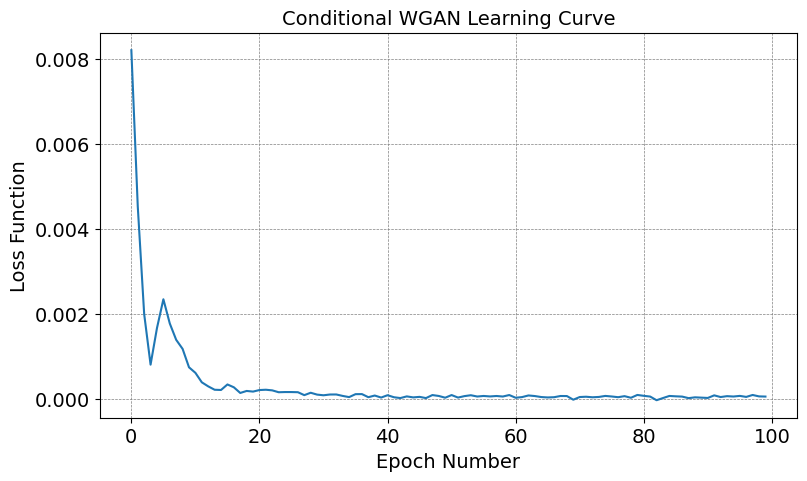

In [24]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [25]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)
X_fake_train = QT.inverse_transform(X_fake_train.cpu().detach().numpy())
X_train = QT.inverse_transform(X_train)

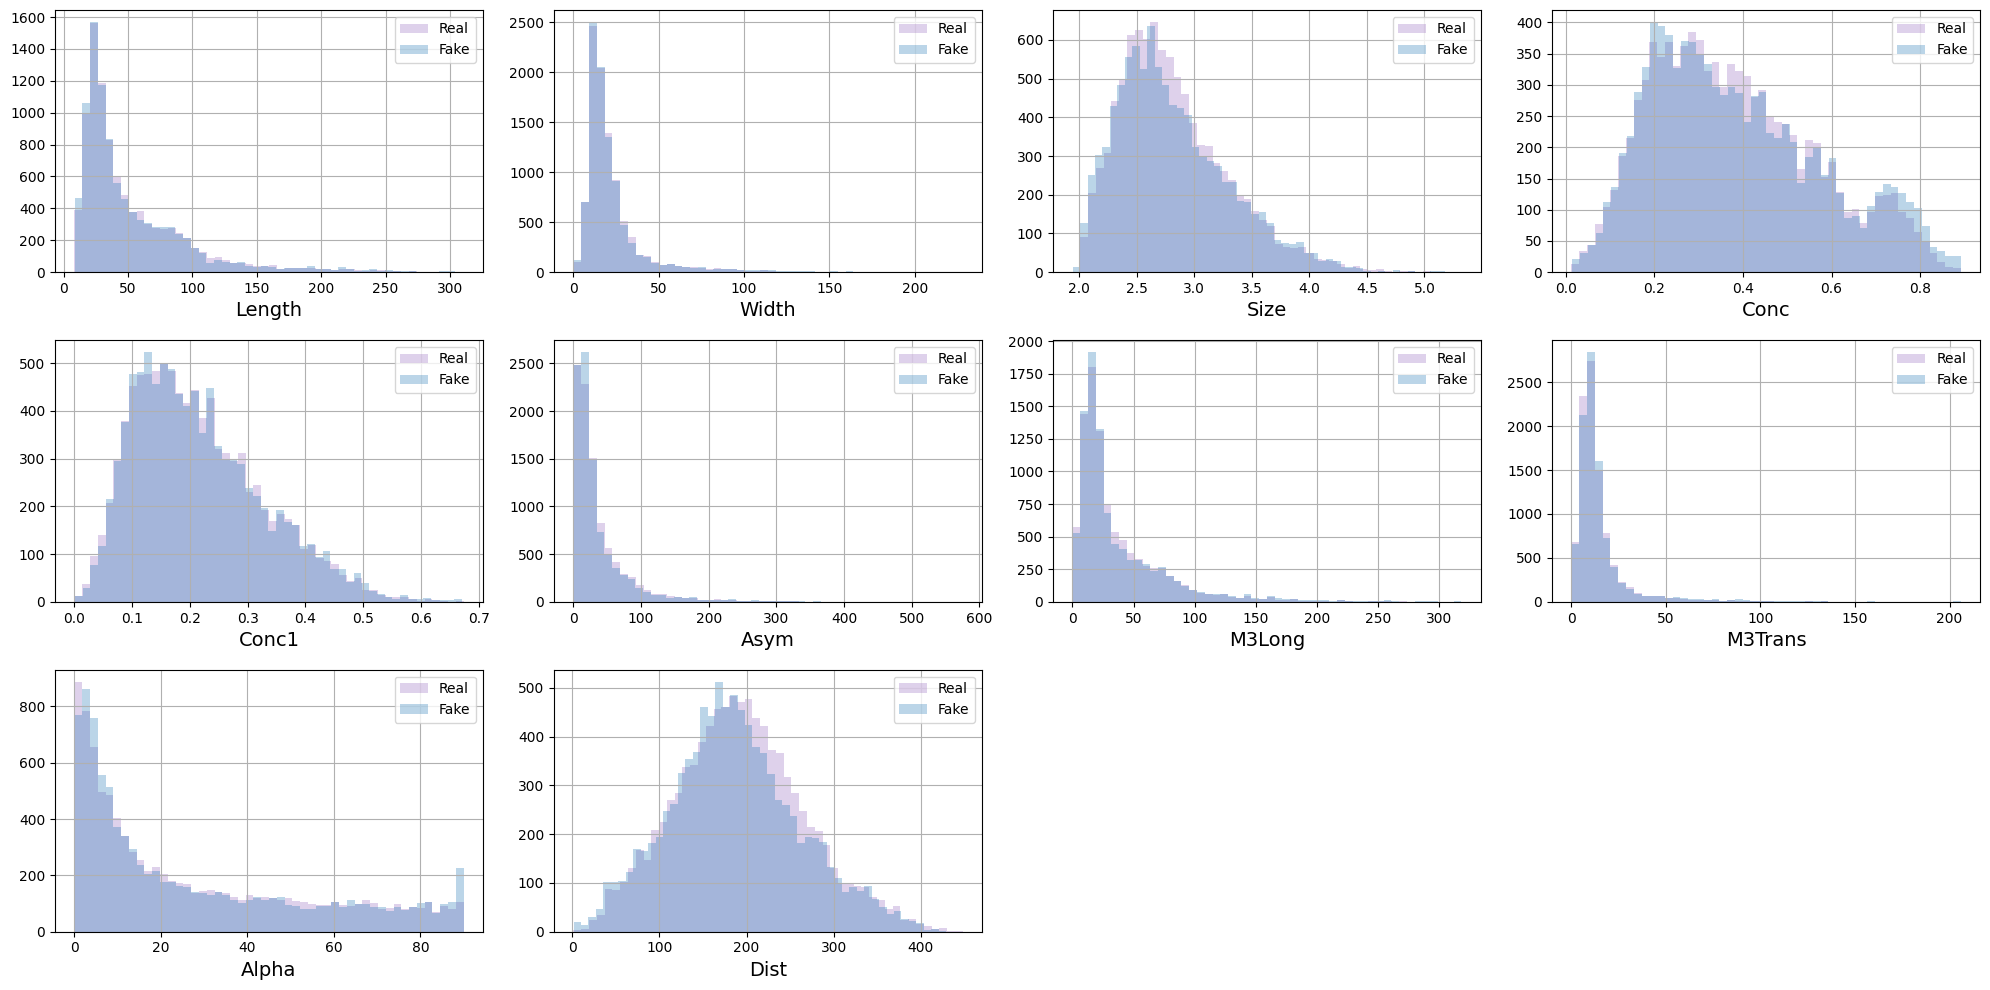

In [26]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [27]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)
X_fake_test = QT.inverse_transform(X_fake_test.cpu().detach().numpy())
X_test = QT.inverse_transform(X_test)

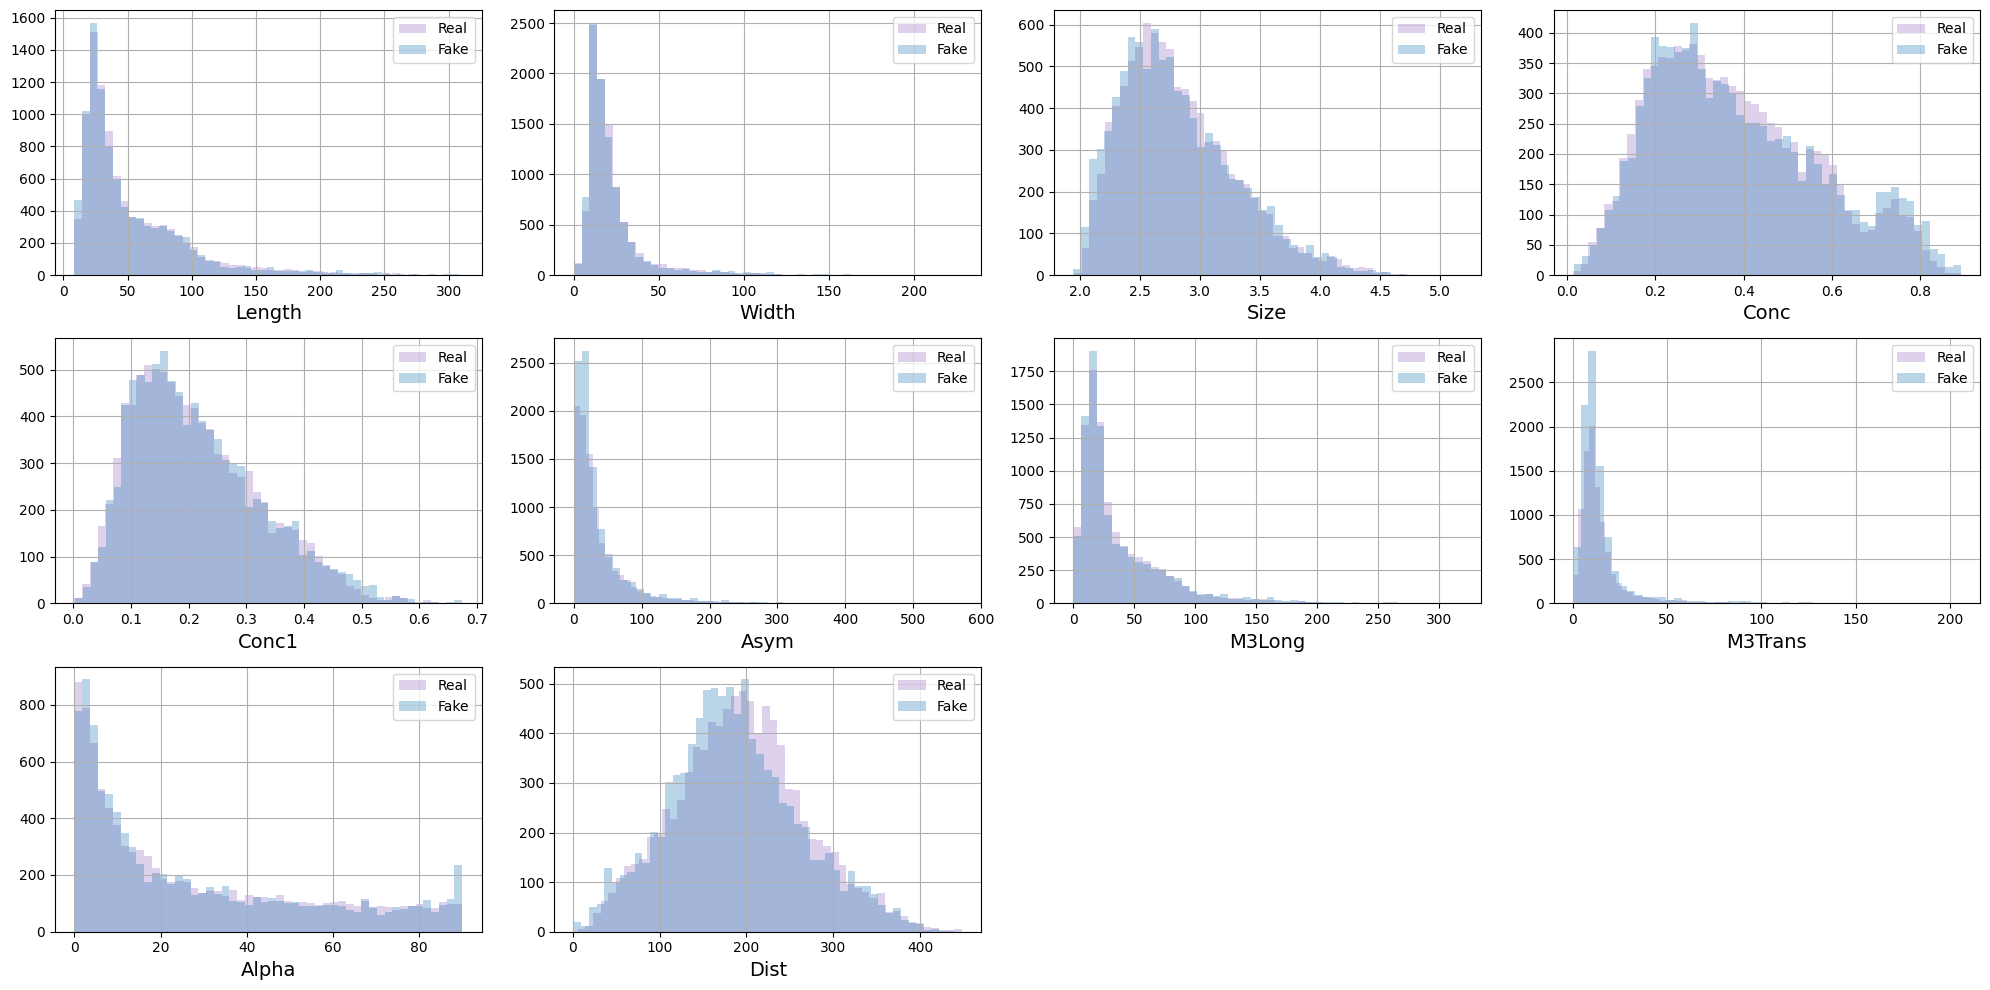

In [28]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Ответьте на вопросы:
- Похожи ли фейковые объекты на реальные?
- Точно ли хорошая идея сравнивать их на глаз?


**Вывод:** Фейковые объекты визуально очень похожи на реальные по форме распределений признаков, но сравнивать объекты на глаз не является хорошей идей, так как в 10-мерном пространстве (10 признаков) объекты могут сильно отличаться, но их проекции на одну ось будут схожи, поэтому нужно делать выводы, учитывая полное пространство.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [29]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [31]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7130613798525213


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


**Вывод:** В данном эксперименте мы создали генератор и классификатор, которые соперничают друг с другом, с целью создания таких данных, которые даже сильный классификатор не сможет отличить от реальных. Мы использовали два классификатора: логистическую регрессию и градиентный бустинг. В конце обучения логистическая регрессия выдавала accuracy score = 0.52, что близко к нашему желаемому результату (0.502), accuracy score бустинга был несколько выше (0.594), но также приемлимый для нас. После этого мы сгенерировали новые данные и визуально и с помощью градиентного бустинга проверили их на схожесть.
В целом, мы получили средние по качеству результаты, так как ROC AUC составил 0.71, что хотябы ближе к 0.5, а не к 1. Больше всего нас удовлетворяет значение ROC AUC = 0.5, так как это можно сравнить со случайным угадывание, то есть классификатор не может отличить классы, что говорит о успешной генерации похожих данных.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Воспользуйтесь [DDPMScheduler](https://huggingface.co/docs/diffusers/api/schedulers/ddpm), возьмите 1000 шагов и подумайте, надо ли указать ещё какой-то параметр.

__Подсказка__: Посмотрите на распределения выше и почитайте описание шедулера в документации. Один из параметров - наследие от использования в генерации картинок, а у нас не картинки.

In [278]:
from sklearn.preprocessing import QuantileTransformer
QT = QuantileTransformer(output_distribution='normal')
X_train = QT.fit_transform(X_train)
X_test = QT.transform(X_test)

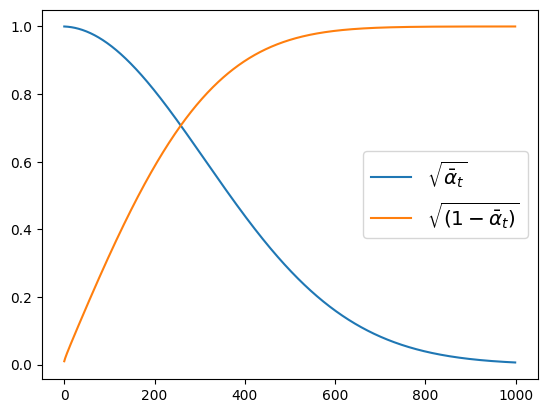

In [14]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample=False)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качестве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [21]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, t, y):
        zty = torch.cat((z.to(DEVICE), t.to(DEVICE), y.to(DEVICE)), dim=1)
        return self.net(zty)

**Вывод:** в обучении будем измерять MSE loss того, насколько модель хорошо восстанавливает шум, добавленный к реальным данным, и минимизирует ошибку между предсказанием и оригинальным шумом. Качество будем измерять таким же методом, как в GAN, так как задачи аналогичны.

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [17]:
def generate_with_diffusion(model, y, latent_dim, sheduler):
    x = torch.randn(len(y), latent_dim, device=DEVICE)
    y = torch.tensor(y, dtype=torch.float, device=DEVICE)
    for t in noise_scheduler.timesteps:
        with torch.no_grad():
            residual = model(x, t.expand(x.shape[0], 1), y)
        x = noise_scheduler.step(residual, t, x).prev_sample
    return x

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [22]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)
                noise = torch.randn_like(real_batch)
                timesteps = torch.randint(0, 999, (real_batch.shape[0], 1)).long().to(DEVICE)
                noisy_real_batch = noise_scheduler.add_noise(real_batch, noise, timesteps)

                pred = self.model(noisy_real_batch, timesteps, cond_batch)

                loss_fn = nn.MSELoss()

                loss = loss_fn(pred, noise)

                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()

                loss_epoch += loss.item()

            # caiculate and store loss after an epoch
            self.loss_history.append(loss_epoch)

            if epoch % 100 == 0:
                indexes = torch.randperm(len(X_real))[:1000]

                X_real_sample = torch.tensor(X_real[indexes], dtype=torch.float, device=DEVICE)
                y_real_sample = torch.ones((1000, 1))

                y_fake = torch.randint(0, 2, (1000, 1), device=DEVICE)
                X_fake_sample = generate_with_diffusion(self.model, y_fake, latent_dim, noise_scheduler)
                y_fake_sample = torch.zeros((1000, 1))

                other_agent_score(X_real_sample.cpu().detach().numpy(), y_real_sample.cpu().detach().numpy(),
                                      X_fake_sample.cpu().detach().numpy(), y_fake_sample.cpu().detach().numpy())

        # Turn off training
        self.model.train(False)

Обучим модель на данных, указав количество входов.

У вас есть скрытое пространство и его размер, есть таймстепы и есть условие. Как легко догадаться, размер входа будет больше, чем просто размер скрытого пространства.

In [23]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1] + 1, n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=1000,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

Linear regression score: 0.736
Boosting score: 1.0
Linear regression score: 1.0
Boosting score: 1.0
Linear regression score: 1.0
Boosting score: 1.0
Linear regression score: 1.0
Boosting score: 1.0
Linear regression score: 0.998
Boosting score: 0.998
Linear regression score: 0.998
Boosting score: 1.0
Linear regression score: 1.0
Boosting score: 1.0
Linear regression score: 0.998
Boosting score: 1.0
Linear regression score: 0.996
Boosting score: 0.998
Linear regression score: 0.954
Boosting score: 1.0
CPU times: user 10min 9s, sys: 2.09 s, total: 10min 11s
Wall time: 10min 15s


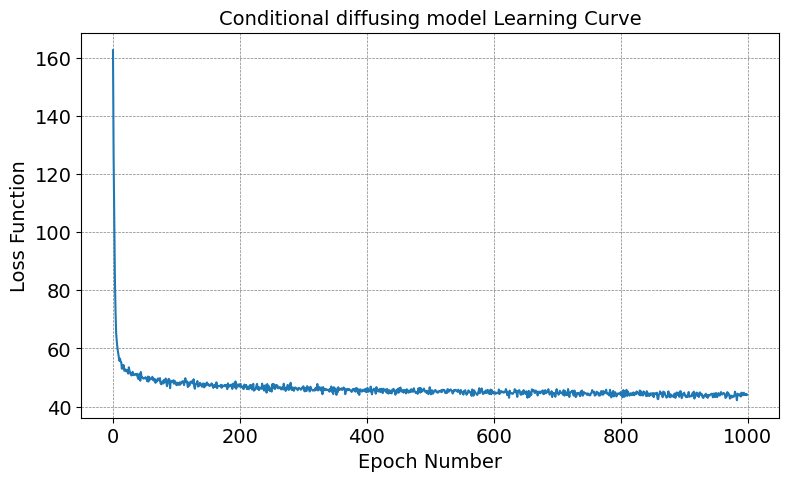

In [24]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [25]:
X_fake_train = generate_with_diffusion(model, y_train, latent_dim, noise_scheduler)
X_fake_train = QT.inverse_transform(X_fake_train.cpu().detach().numpy())
X_train = QT.inverse_transform(X_train)

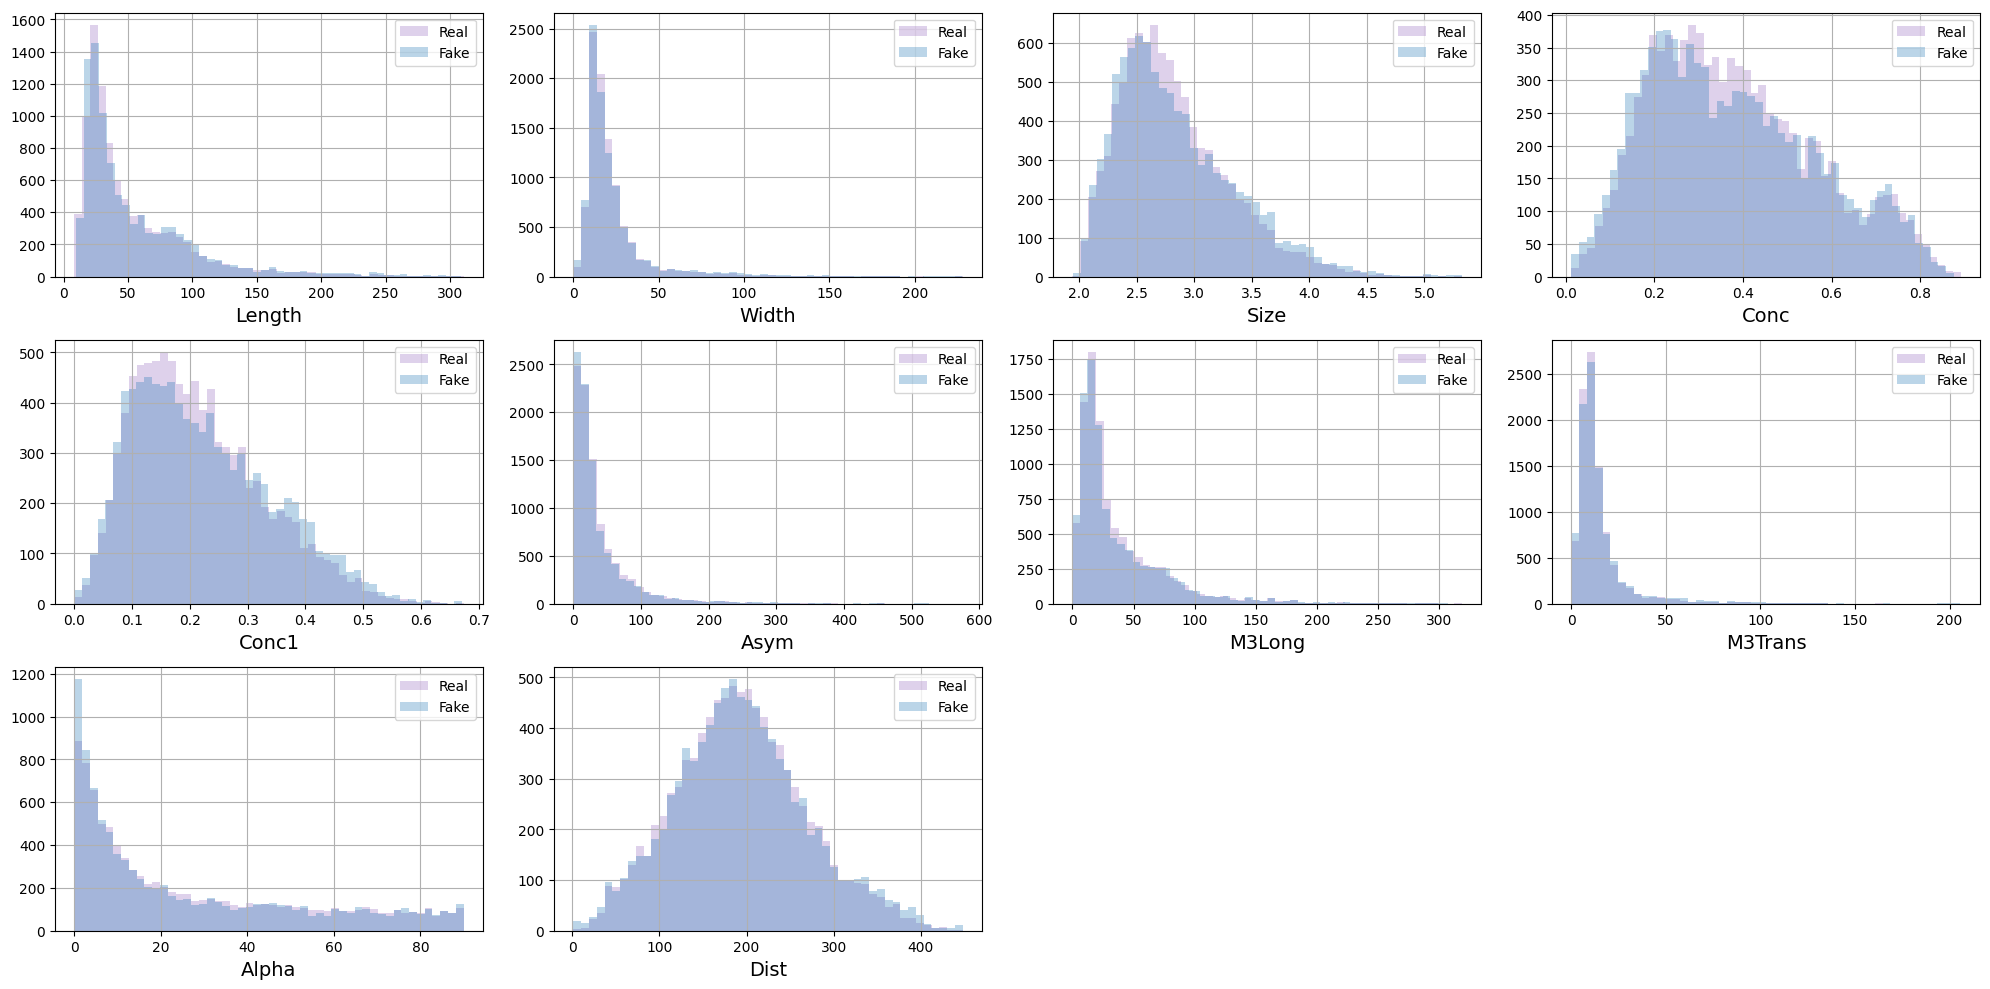

In [26]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [27]:
X_fake_test = generate_with_diffusion(model, y_test, latent_dim, noise_scheduler)
X_fake_test = QT.inverse_transform(X_fake_test.cpu().detach().numpy())
X_test = QT.inverse_transform(X_test)

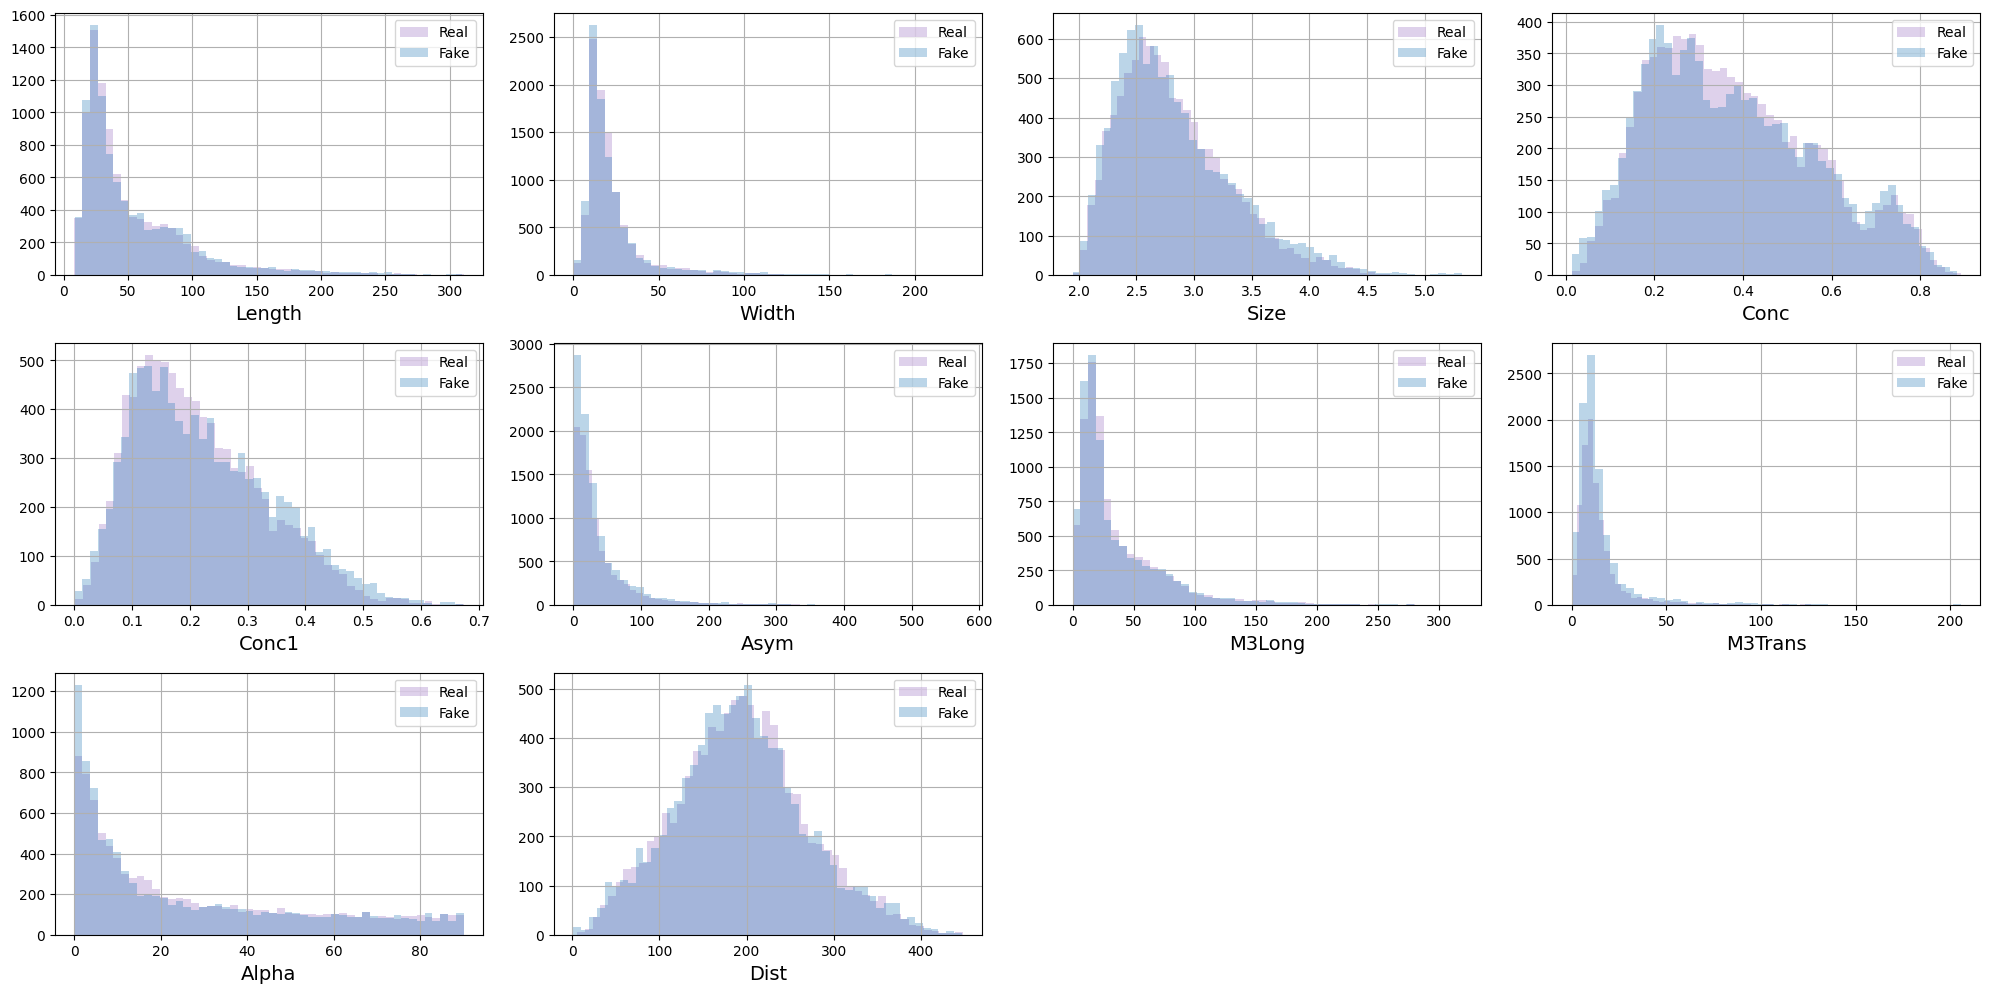

In [28]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

In [29]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [31]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7088930905649153


In [32]:
aucсuracy_score = accuracy_score(yy_test, clf.predict(XX_test))
print("accuracy_score = ", aucсuracy_score)

accuracy_score =  0.6488958990536278


**Вывод:** Мы получили очень схожие результаты с GAN моделью: ROC AUC на 0.5% ниже, но это может быть связано только с разным random_seed. В целом, результаты средние, но ROC AUC хотябы ближе к 0.5, а не к 1. Также модели отличаются тем, что в процессе обучения логистическая регрессия и градиентый бустинг выдают значения accuracy score близкое к 1, но после обратного трансформирования данных это значение равно 0.65 для градиентого бустинга, видимо, в преобразованных данных диффузионная модель не может генерировать очень похожие объекты.

# Бонус (2 балла)

Кроме Diffusion и GAN вы изучили еще VAE и NF. В качестве бонуса релизуйте VAE, обучите, и в конце сравните качество теми же методами, что и в основной части ДЗ.

Разбалловка бонуса такая:
- Реализовать VAE - 1 балл
- Обучить VAE - 0.5 балла
- Провести сравнение с GAN и Diffusion аналогично 14 заданию основной части - 0.5 балла

Ниже приведены шаблоны. Они не особо щедры на комментарии, но поскольку задача бонусная, ожидаем, что вы в них разберетесь. Если они вам не нравятся - можете переписать как хотите.

Если же VAE вам кажется слишком скучным, то мы засчитаем реализацию NF, но шаблонов не предоставим. Бонус в таком случае тоже ограничен сверху 2 баллами и разбалловка не изменится.

In [149]:
from sklearn.preprocessing import QuantileTransformer
QT = QuantileTransformer(output_distribution='normal')
X_train = QT.fit_transform(X_train)
X_test = QT.transform(X_test)

In [256]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size):
        super(Encoder, self).__init__()

        self.enc_net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
        )

        self.mu = nn.Linear(100, lat_size)
        self.log_sigma = nn.Linear(100, lat_size)

    def forward(self, x, y):
        z = torch.cat((x, y), dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        return mu, log_sigma


class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Decoder, self).__init__()

        self.dec_net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
        )

    def forward(self, z, y):
        z_cond = torch.cat((z.to(DEVICE), y.to(DEVICE)), dim=1)
        x_rec = self.dec_net(z_cond)
        return x_rec

def generate(decoder, y, latent_dim):
    X_fake = decoder(torch.randn(len(y), latent_dim), torch.tensor(y).float())
    return X_fake

In [257]:
class VAEFitter(object):
    def __init__(
        self,
        encoder,
        decoder,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        KL_weight=0.001,
    ):

        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight

        self.criterion = nn.MSELoss()
        self.opt = torch.optim.Adam(
            list(self.encoder.parameters()) + list(self.decoder.parameters()),
            lr=self.lr,
        )

        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)

    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(DEVICE)
        return mu + torch.exp(log_sigma / 2) * eps

    def custom_loss(self, x, rec_x, mu, log_sigma):
        KL = torch.mean(
            -0.5 * torch.sum(1 + log_sigma - mu**2 - log_sigma.exp(), dim=1), dim=0
        )
        recon_loss = self.criterion(x, rec_x)
        return KL * self.KL_weight + recon_loss

    def compute_loss(self, x_batch, cond_batch):

        mu, log_sigma = self.encoder(x_batch, cond_batch)
        z = self.sample_z(mu, log_sigma)
        rec_x = self.decoder(z, cond_batch)

        loss = self.custom_loss(x_batch, rec_x, mu, log_sigma)

        return loss

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.encoder.train(True)
        self.decoder.train(True)

        self.loss_history = []

        # Fit
        for epoch in range(self.n_epochs):
            for i, (x_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                # caiculate loss
                loss = self.compute_loss(x_batch, cond_batch)

                # optimization step
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()

            # caiculate and store loss after an epoch
            loss_epoch = self.compute_loss(X_real, y_cond)
            self.loss_history.append(loss_epoch.detach().cpu())

        # Turn off training
        self.encoder.train(False)
        self.decoder.train(False)

In [258]:
%%time
latent_dim = 10
encoder = Encoder(n_inputs=X_train.shape[1] + 1, lat_size=latent_dim)
decoder = Decoder(n_inputs=latent_dim + 1, n_outputs=X_train.shape[1])

vae_fitter = VAEFitter(
    encoder=encoder,
    decoder=decoder,
    batch_size=32,
    n_epochs=1500,
    latent_dim=latent_dim,
    lr=0.0001,
    KL_weight=0.0001,
)

vae_fitter.fit(X_train, y_train)

print("Loss history:", vae_fitter.loss_history)

Loss history: [tensor(0.4065), tensor(0.3427), tensor(0.1735), tensor(0.1318), tensor(0.1019), tensor(0.0836), tensor(0.0632), tensor(0.0512), tensor(0.0467), tensor(0.0436), tensor(0.0387), tensor(0.0339), tensor(0.0305), tensor(0.0276), tensor(0.0253), tensor(0.0206), tensor(0.0191), tensor(0.0181), tensor(0.0173), tensor(0.0161), tensor(0.0154), tensor(0.0148), tensor(0.0135), tensor(0.0118), tensor(0.0111), tensor(0.0106), tensor(0.0100), tensor(0.0098), tensor(0.0095), tensor(0.0093), tensor(0.0091), tensor(0.0089), tensor(0.0088), tensor(0.0088), tensor(0.0091), tensor(0.0085), tensor(0.0084), tensor(0.0083), tensor(0.0084), tensor(0.0083), tensor(0.0083), tensor(0.0080), tensor(0.0078), tensor(0.0081), tensor(0.0078), tensor(0.0077), tensor(0.0080), tensor(0.0077), tensor(0.0080), tensor(0.0077), tensor(0.0079), tensor(0.0075), tensor(0.0076), tensor(0.0076), tensor(0.0073), tensor(0.0073), tensor(0.0075), tensor(0.0073), tensor(0.0074), tensor(0.0072), tensor(0.0073), tensor(0.

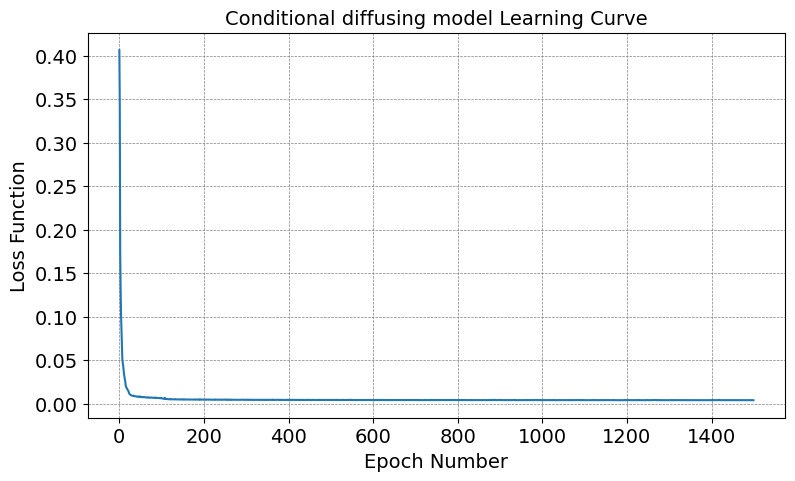

In [259]:
plt.figure(figsize=(9, 5))
plt.plot(vae_fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

In [270]:
X_fake_train = generate(decoder, y_train, latent_dim)
X_fake_train = QT.inverse_transform(X_fake_train.cpu().detach().numpy())
X_train = QT.inverse_transform(X_train)

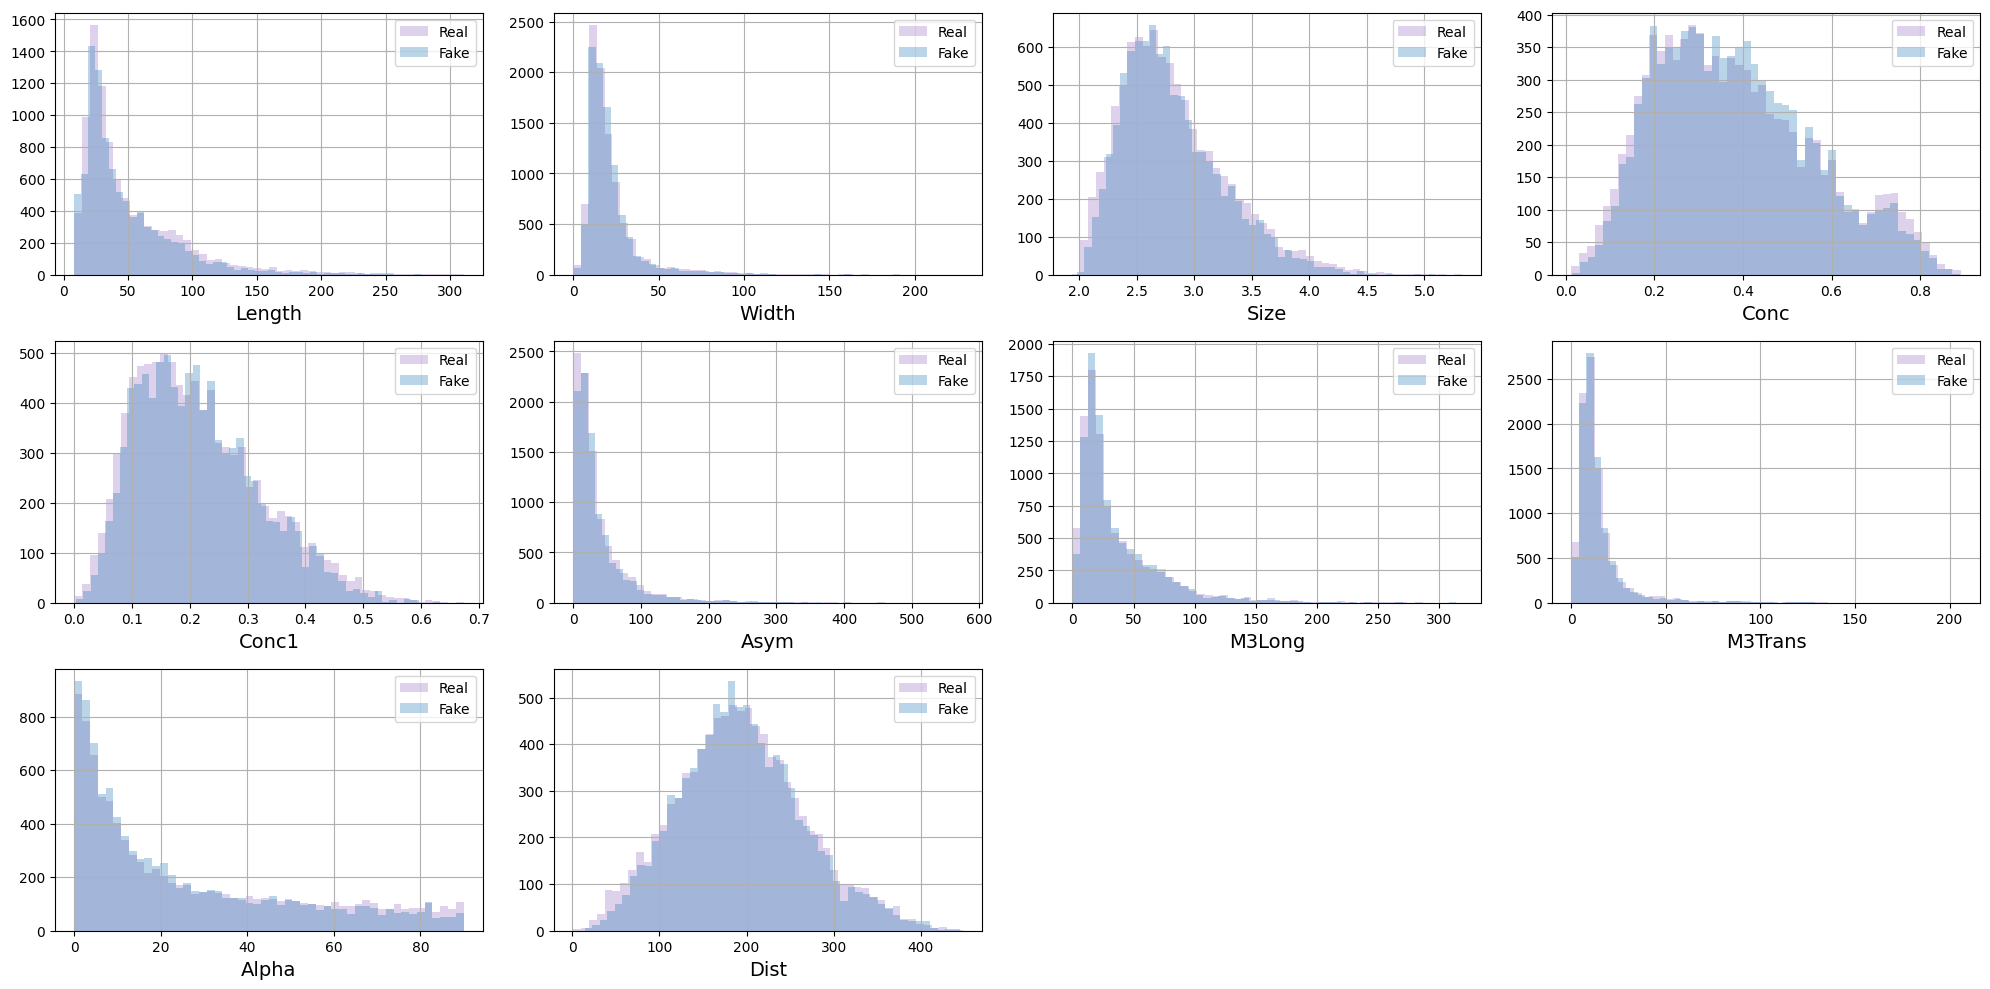

In [271]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [272]:
X_fake_test = generate(decoder, y_test, latent_dim)
X_fake_test = QT.inverse_transform(X_fake_test.cpu().detach().numpy())
X_test = QT.inverse_transform(X_test)

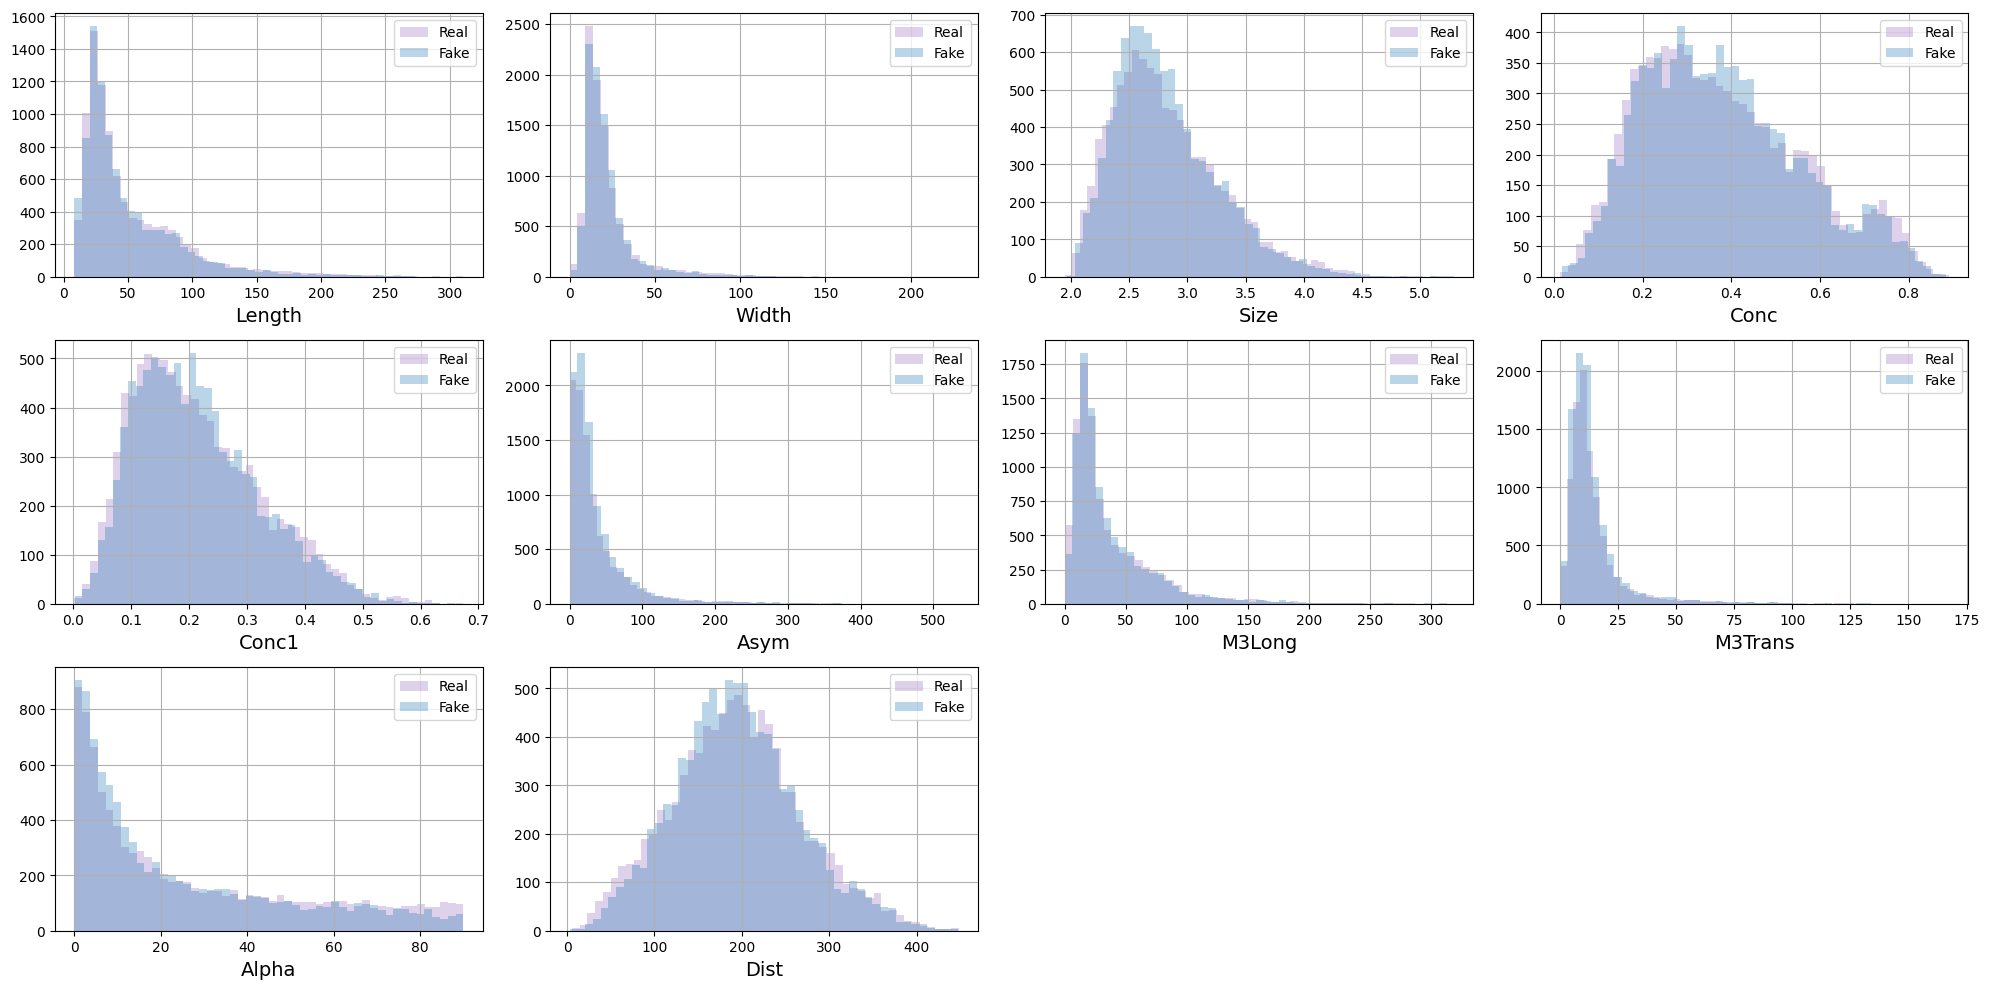

In [273]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

In [274]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [275]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [276]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7464970350541409


In [277]:
aucсuracy_score = accuracy_score(yy_test, clf.predict(XX_test))
print("accuracy_score = ", aucсuracy_score)

accuracy_score =  0.6802313354363827


**Вывод:** VAE показывает результат чуть хуже, чем GAN и Diffusion: ROC AUC выше на 4%, а accuracy_score на 3%, однако  многое зависит от оптимальных гиперпараметров и архитектору модели, небольшим перебором я смог снизить ROC AUC с 0.95 до 0.8, но на большее количество экспериментов у меня уже не хватало времени. Также при большом количестве эпох результаты получаются существенно лучше.

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

In [ ]:
GOOD